In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import os 
os.environ["CUDA_VISIBLE_DEVICES"]="0"
from cifar_model import generator,discriminator,cnn
import utils

/home/data/bruno/anaconda3/envs/tf-1.4-env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


'''
build unl data pipeline 
train gan cifar10 kinglsey
generate adv pert
train takeru or simple cnn cifar
get gains !
gamma = 0.03 eta = 1 epsilon = 20
'''

In [2]:
params = dict(
    batch_size = 50,
    seed = 1234,
    z_dim = 100,
    lr = 1e-4,
    logdir = 'cifar_gans/',
    name_model = 'model_kingsley'
)
rng = np.random.RandomState(params['seed'])  # seed labels

In [19]:
params_dnn = dict(
    batch=50,
    lr = 1e-4,
    labeled = 100,
    seed = 1234,
    epoch=501
)

## Data

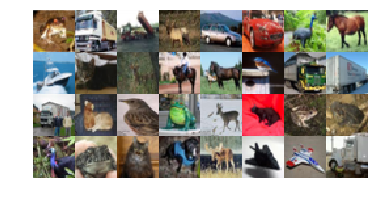

In [4]:
(trainx, trainy), (testx, testy) = tf.keras.datasets.cifar10.load_data()
def rescale(mat):
    return ((-127.5 + mat) / 127.5)
trainx = rescale(trainx)
testx = rescale(testx)
trainy = np.squeeze(trainy)
testy = np.squeeze(testy)
trainx_unl = trainx.copy()
nr_batch_unl = trainx_unl.shape[0] // params['batch_size']
utils.show_cifar(trainx_unl[:32])

train: (1000, 32, 32, 3) test: (10000, 32, 32, 3)


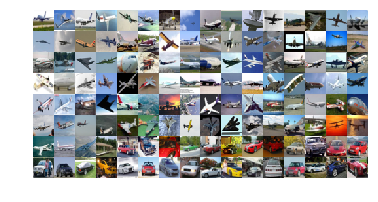

In [5]:
inds = rng.permutation(trainx.shape[0])
trainx = trainx[inds]
trainy = trainy[inds]
txs = []
tys = []
for j in range(10):
    txs.append(trainx[trainy == j][:params_dnn['labeled']])
    tys.append(trainy[trainy == j][:params_dnn['labeled']])
txs = np.concatenate(txs, axis=0)
tys = np.concatenate(tys, axis=0)
trainx = txs
trainy = tys
nr_batch_train = trainx.shape[0] // params_dnn['batch']
nr_batch_test = testx.shape[0] // params_dnn['batch']
print('train:',trainx.shape,'test:',testx.shape)
utils.show_cifar(trainx[:128])

## GAN training

In [6]:
unl = tf.placeholder(tf.float32, [params['batch_size'], 32,32,3])
is_training_pl = tf.placeholder(tf.bool, [], name='is_training_pl')
noise = tf.random_normal(shape=[params['batch_size'],params['z_dim']])

samples = generator(noise,is_training=is_training_pl,reuse=tf.AUTO_REUSE)
real_score = discriminator(unl,is_training=is_training_pl,reuse=tf.AUTO_REUSE)
fake_score = discriminator(samples,is_training=is_training_pl,reuse=tf.AUTO_REUSE)

gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "generator")
disc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discriminator") 

loss_g = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_score,labels=tf.ones_like(fake_score)))
loss_d = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=real_score,labels=tf.ones_like(fake_score)))+\
tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_score,labels=tf.zeros_like(fake_score)))

optimizer = tf.train.AdamOptimizer(learning_rate=params['lr'], beta1=0.5)

update_ops_gen = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='generator')
update_ops_dis = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='discriminator')

with tf.control_dependencies(update_ops_gen): # attached op for moving average batch norm
    traing = optimizer.minimize(loss_g,var_list=gen_vars)
with tf.control_dependencies(update_ops_dis):
    traind = optimizer.minimize(loss_d,var_list=disc_vars)

In [7]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [8]:
saver = tf.train.Saver()

In [9]:
path = './gan_cifar_saved/'
if tf.train.latest_checkpoint(path) is not None:
    path = saver.restore(sess, tf.train.latest_checkpoint(path))
else:
    print('no model found')

INFO:tensorflow:Restoring parameters from ./gan_cifar_saved/kingsley


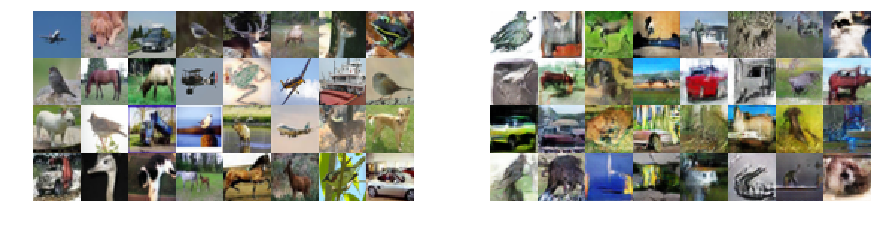

KeyboardInterrupt: 

In [10]:
viz_every = 500
for epoch in tqdm(range(10001)):
    trainx_unl = trainx_unl[rng.permutation(trainx_unl.shape[0])]  # shuffling unl dataset   
    
    for step in range(nr_batch_unl):
        ran_from = step * params['batch_size']
        ran_to = (step + 1) * params['batch_size']
        sess.run(traind,{is_training_pl:True,unl:trainx_unl[ran_from:ran_to]})
        sess.run(traing,{is_training_pl:True,unl:trainx_unl[ran_from:ran_to]})

        if (step) % viz_every == 0:
            xx, yy = sess.run([unl,samples],{is_training_pl:False,unl:trainx_unl[ran_from:ran_to]})
            plt.figure(figsize=(15,5))
            plt.subplot(121)
            utils.show_cifar(xx[:32])
            plt.subplot(122)
            utils.show_cifar(yy[:32])
            plt.show()


In [19]:
saver.save(sess, './gan_cifar_saved/kingsley')

'./gan_cifar_saved/kingsley'

## Vizualization manifold examples

In [11]:
# ############ MANIFOLD ##########
z1 = tf.random_normal(shape=[params['batch_size'],params['z_dim']])
pert_n = tf.nn.l2_normalize(tf.random_normal(shape=[params['batch_size'],params['z_dim']]),dim=[1])
z1_pert = z1 + 1. * pert_n
pz = tf.random_normal([params['batch_size'],32,32,1],stddev=0.2) 

samp_z1 = generator(z1,is_training=is_training_pl,reuse=tf.AUTO_REUSE)
samp_z2 = generator(z1_pert,is_training=is_training_pl,reuse=tf.AUTO_REUSE)
samp_adv = samp_z1 + 20.* tf.nn.l2_normalize(samp_z2-samp_z1,dim=[1,2,3])

In [12]:
xx,yy = sess.run([samp_z1,samp_adv],{is_training_pl:False})
xx = (xx+1.)/2.
yy = (yy+1.)/2.
yy[yy>1.]=1
yy[yy<0]=0

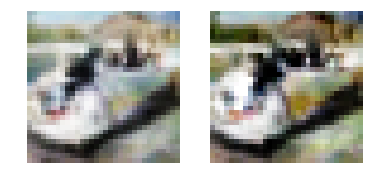

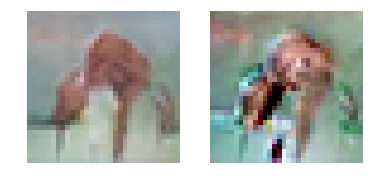

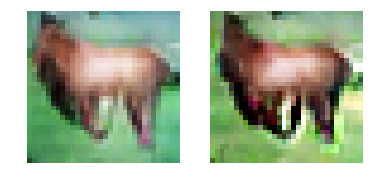

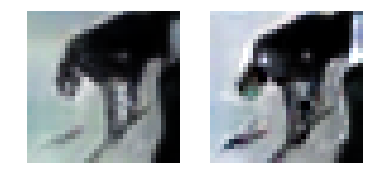

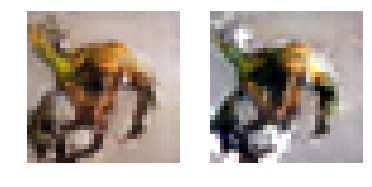

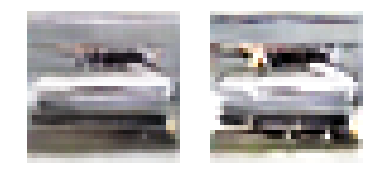

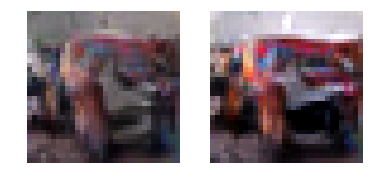

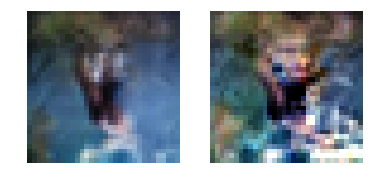

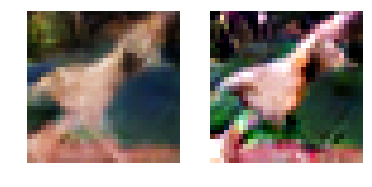

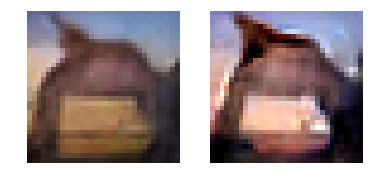

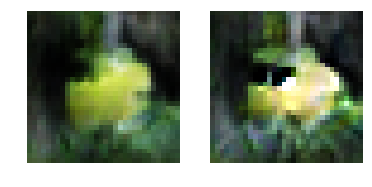

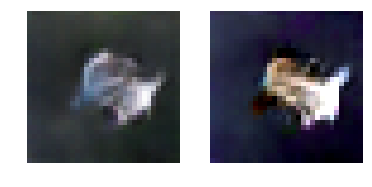

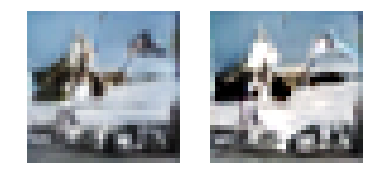

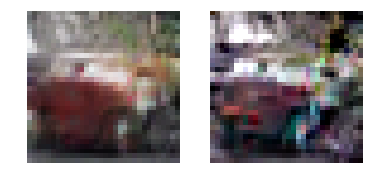

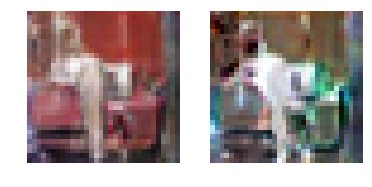

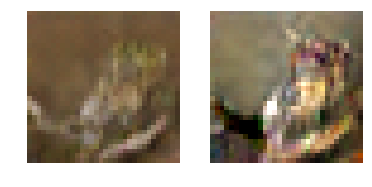

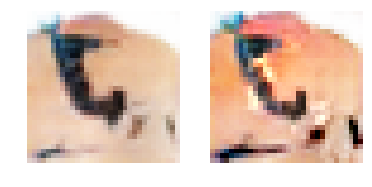

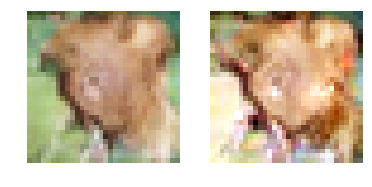

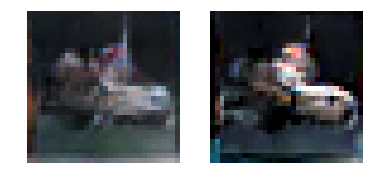

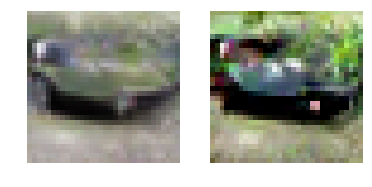

In [13]:
for idx in range(20):
    plt.subplot(1,2,1)
    plt.imshow(np.squeeze(xx[idx]))
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(np.squeeze(yy[idx]))
    plt.axis('off')
    plt.show()

## Training CNN

In [14]:
inp = tf.placeholder(tf.float32, [params_dnn['batch'], 32,32,3])
lbl = tf.placeholder(tf.int64, [params_dnn['batch']])
training_cnn  = tf.placeholder(tf.bool,[])
logits = cnn(inp,training_cnn)
xloss = tf.losses.sparse_softmax_cross_entropy(logits=logits,labels=lbl)

In [41]:
logits_z1= cnn(samp_z1,training_cnn)
logits_z2 = cnn(samp_z2+pz,training_cnn)
logits_adv = cnn(samp_adv,training_cnn) # ADD PZ 

manifold = tf.reduce_sum(tf.sqrt(tf.square(logits_z1-logits_adv)+1e-8),axis=1)
manifold_loss = tf.reduce_mean(manifold)

In [42]:
loss = xloss + 0.01 * manifold_loss

In [43]:
with tf.variable_scope("adam",reuse=tf.AUTO_REUSE):
    global_step = tf.Variable(0, name='global_step',trainable=False)
    optimizer = tf.train.AdamOptimizer(learning_rate=params_dnn['lr'])
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS,scope='classifier')  # control dependencies for batch norm ops
    with tf.control_dependencies(update_ops):
        train_op = optimizer.minimize(loss,var_list=tf.trainable_variables(scope='classifier'),global_step=global_step)
        
correct_prediction = tf.equal(tf.argmax(logits,1),lbl)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [44]:
#init
var = tf.global_variables(scope='classifier')+tf.global_variables(scope='adam')
init_op = tf.variables_initializer(var_list=var)

In [45]:
sess.run(init_op)
train_array = [];test_array=[]; loss_array=[]; manifold_array=[]


Epoch: 0,Global steps: 20, xloss: 2.24733, maniloss: 2.03735, training acc: 17.00%, test acc: 10.00%
Epoch: 1,Global steps: 40, xloss: 2.02486, maniloss: 2.97796, training acc: 26.30%, test acc: 11.22%
Epoch: 2,Global steps: 60, xloss: 1.90280, maniloss: 3.56108, training acc: 31.30%, test acc: 16.82%
Epoch: 3,Global steps: 80, xloss: 1.81323, maniloss: 3.87200, training acc: 34.20%, test acc: 18.76%
Epoch: 4,Global steps: 100, xloss: 1.75224, maniloss: 4.15352, training acc: 37.30%, test acc: 19.27%
Epoch: 5,Global steps: 120, xloss: 1.69595, maniloss: 4.35179, training acc: 39.00%, test acc: 20.76%
Epoch: 6,Global steps: 140, xloss: 1.65806, maniloss: 4.59612, training acc: 40.30%, test acc: 19.12%
Epoch: 7,Global steps: 160, xloss: 1.61126, maniloss: 4.67271, training acc: 41.90%, test acc: 19.75%
Epoch: 8,Global steps: 180, xloss: 1.59416, maniloss: 4.96585, training acc: 43.90%, test acc: 21.49%
Epoch: 9,Global steps: 200, xloss: 1.52572, maniloss: 5.06205, training acc: 48.10%, 

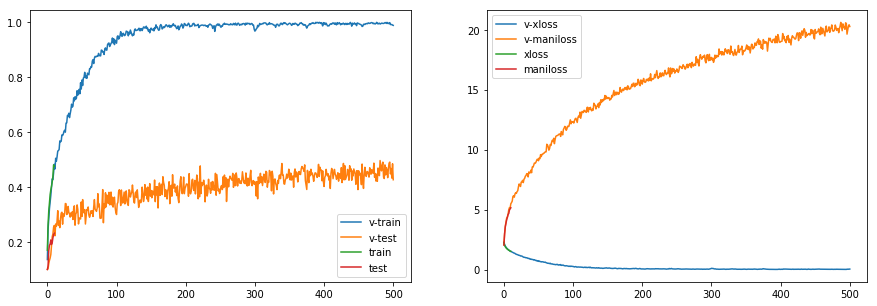

Epoch: 11,Global steps: 240, xloss: 1.46350, maniloss: 5.33305, training acc: 48.20%, test acc: 24.19%
Epoch: 12,Global steps: 260, xloss: 1.42960, maniloss: 5.52137, training acc: 50.10%, test acc: 25.67%
Epoch: 13,Global steps: 280, xloss: 1.40296, maniloss: 5.44515, training acc: 51.00%, test acc: 27.18%
Epoch: 14,Global steps: 300, xloss: 1.41623, maniloss: 5.80590, training acc: 49.50%, test acc: 23.77%
Epoch: 15,Global steps: 320, xloss: 1.36338, maniloss: 5.73004, training acc: 54.70%, test acc: 25.08%
Epoch: 16,Global steps: 340, xloss: 1.31998, maniloss: 5.79605, training acc: 54.00%, test acc: 26.20%
Epoch: 17,Global steps: 360, xloss: 1.29869, maniloss: 5.97079, training acc: 55.80%, test acc: 28.62%
Epoch: 18,Global steps: 380, xloss: 1.27496, maniloss: 5.97952, training acc: 57.90%, test acc: 25.61%
Epoch: 19,Global steps: 400, xloss: 1.26912, maniloss: 5.98274, training acc: 56.70%, test acc: 26.83%
Epoch: 20,Global steps: 420, xloss: 1.21437, maniloss: 6.16671, training 

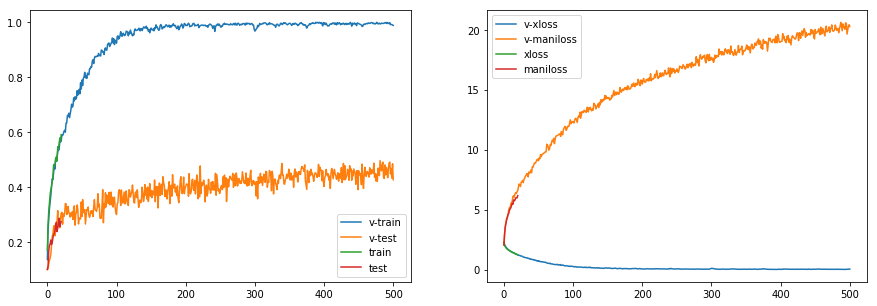

Epoch: 21,Global steps: 440, xloss: 1.19526, maniloss: 6.19469, training acc: 60.00%, test acc: 28.99%
Epoch: 22,Global steps: 460, xloss: 1.18099, maniloss: 6.25168, training acc: 61.60%, test acc: 31.54%
Epoch: 23,Global steps: 480, xloss: 1.14721, maniloss: 6.42867, training acc: 59.60%, test acc: 29.50%
Epoch: 24,Global steps: 500, xloss: 1.14023, maniloss: 6.34088, training acc: 63.60%, test acc: 29.19%
Epoch: 25,Global steps: 520, xloss: 1.09658, maniloss: 6.58955, training acc: 64.40%, test acc: 29.75%
Epoch: 26,Global steps: 540, xloss: 1.08200, maniloss: 6.76169, training acc: 63.80%, test acc: 30.87%
Epoch: 27,Global steps: 560, xloss: 1.04079, maniloss: 6.60253, training acc: 65.50%, test acc: 28.72%
Epoch: 28,Global steps: 580, xloss: 1.04522, maniloss: 6.88412, training acc: 66.00%, test acc: 31.64%
Epoch: 29,Global steps: 600, xloss: 1.00677, maniloss: 6.91780, training acc: 67.20%, test acc: 27.23%
Epoch: 30,Global steps: 620, xloss: 1.01581, maniloss: 6.95966, training 

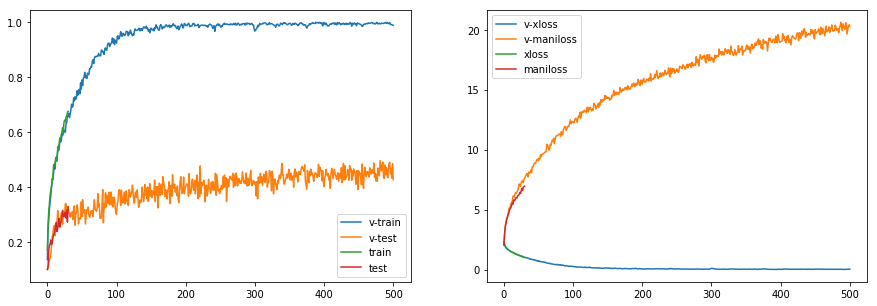

Epoch: 31,Global steps: 640, xloss: 0.98607, maniloss: 7.02471, training acc: 68.50%, test acc: 28.58%
Epoch: 32,Global steps: 660, xloss: 0.96783, maniloss: 7.20615, training acc: 67.30%, test acc: 32.37%
Epoch: 33,Global steps: 680, xloss: 0.94150, maniloss: 7.28417, training acc: 68.60%, test acc: 30.20%
Epoch: 34,Global steps: 700, xloss: 0.93246, maniloss: 7.24065, training acc: 69.40%, test acc: 30.43%
Epoch: 35,Global steps: 720, xloss: 0.93496, maniloss: 7.33169, training acc: 68.40%, test acc: 31.60%
Epoch: 36,Global steps: 740, xloss: 0.89524, maniloss: 7.49152, training acc: 71.80%, test acc: 31.82%
Epoch: 37,Global steps: 760, xloss: 0.89659, maniloss: 7.58992, training acc: 71.20%, test acc: 29.31%
Epoch: 38,Global steps: 780, xloss: 0.88021, maniloss: 7.51937, training acc: 71.90%, test acc: 32.05%
Epoch: 39,Global steps: 800, xloss: 0.85277, maniloss: 7.50101, training acc: 71.70%, test acc: 34.52%
Epoch: 40,Global steps: 820, xloss: 0.82780, maniloss: 7.53987, training 

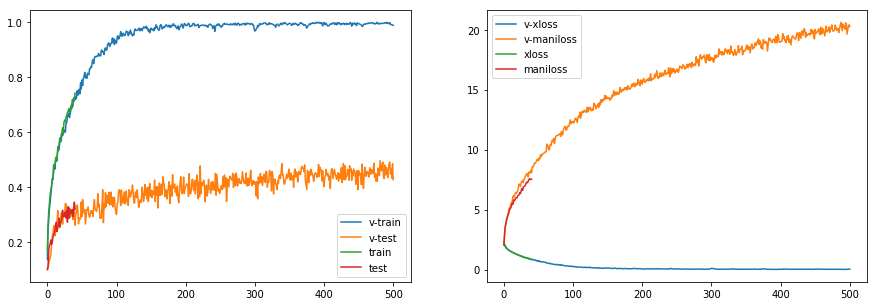

Epoch: 41,Global steps: 840, xloss: 0.82485, maniloss: 7.71875, training acc: 73.30%, test acc: 34.71%
Epoch: 42,Global steps: 860, xloss: 0.79668, maniloss: 7.74436, training acc: 74.60%, test acc: 34.59%
Epoch: 43,Global steps: 880, xloss: 0.79159, maniloss: 7.99740, training acc: 75.20%, test acc: 31.53%
Epoch: 44,Global steps: 900, xloss: 0.79530, maniloss: 7.99586, training acc: 74.80%, test acc: 32.65%
Epoch: 45,Global steps: 920, xloss: 0.74410, maniloss: 8.08040, training acc: 76.90%, test acc: 29.93%
Epoch: 46,Global steps: 940, xloss: 0.72904, maniloss: 8.25845, training acc: 78.50%, test acc: 29.37%
Epoch: 47,Global steps: 960, xloss: 0.73110, maniloss: 8.23864, training acc: 78.30%, test acc: 33.86%
Epoch: 48,Global steps: 980, xloss: 0.72492, maniloss: 8.00922, training acc: 76.00%, test acc: 29.87%
Epoch: 49,Global steps: 1000, xloss: 0.72293, maniloss: 8.15890, training acc: 77.90%, test acc: 35.61%
Epoch: 50,Global steps: 1020, xloss: 0.67443, maniloss: 8.42163, trainin

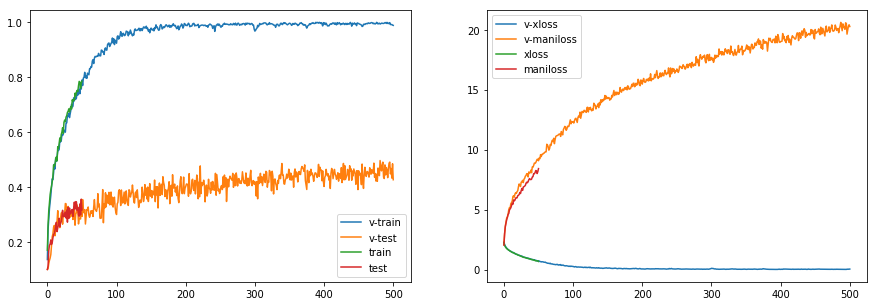

Epoch: 51,Global steps: 1040, xloss: 0.68785, maniloss: 8.53782, training acc: 79.70%, test acc: 34.71%
Epoch: 52,Global steps: 1060, xloss: 0.67131, maniloss: 8.33492, training acc: 79.80%, test acc: 30.52%
Epoch: 53,Global steps: 1080, xloss: 0.64587, maniloss: 8.26682, training acc: 80.30%, test acc: 32.13%
Epoch: 54,Global steps: 1100, xloss: 0.61632, maniloss: 8.46712, training acc: 82.40%, test acc: 30.46%
Epoch: 55,Global steps: 1120, xloss: 0.62333, maniloss: 8.60147, training acc: 81.30%, test acc: 34.50%
Epoch: 56,Global steps: 1140, xloss: 0.61898, maniloss: 8.68971, training acc: 81.00%, test acc: 35.04%
Epoch: 57,Global steps: 1160, xloss: 0.59457, maniloss: 8.68100, training acc: 83.30%, test acc: 33.03%
Epoch: 58,Global steps: 1180, xloss: 0.61734, maniloss: 8.78459, training acc: 82.00%, test acc: 32.60%
Epoch: 59,Global steps: 1200, xloss: 0.54448, maniloss: 8.85343, training acc: 85.10%, test acc: 32.91%
Epoch: 60,Global steps: 1220, xloss: 0.53082, maniloss: 8.89551,

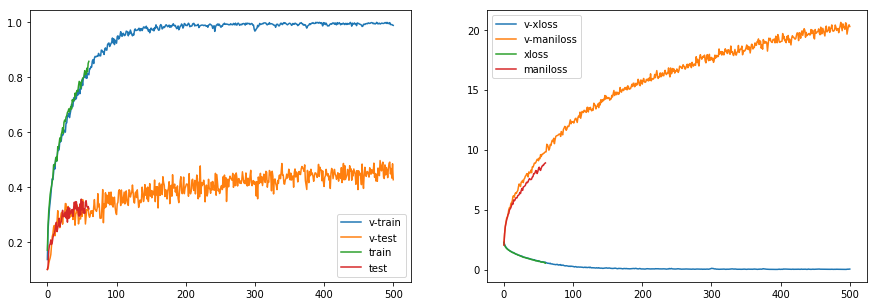

Epoch: 61,Global steps: 1240, xloss: 0.50722, maniloss: 8.96893, training acc: 86.40%, test acc: 32.35%
Epoch: 62,Global steps: 1260, xloss: 0.50583, maniloss: 8.89640, training acc: 86.20%, test acc: 34.00%
Epoch: 63,Global steps: 1280, xloss: 0.52439, maniloss: 8.99332, training acc: 85.30%, test acc: 35.86%
Epoch: 64,Global steps: 1300, xloss: 0.50865, maniloss: 9.24003, training acc: 85.50%, test acc: 35.55%
Epoch: 65,Global steps: 1320, xloss: 0.50294, maniloss: 8.92723, training acc: 86.70%, test acc: 32.82%
Epoch: 66,Global steps: 1340, xloss: 0.48827, maniloss: 9.46905, training acc: 86.60%, test acc: 33.64%
Epoch: 67,Global steps: 1360, xloss: 0.48462, maniloss: 9.30248, training acc: 87.00%, test acc: 37.04%
Epoch: 68,Global steps: 1380, xloss: 0.45320, maniloss: 9.18297, training acc: 87.30%, test acc: 31.22%
Epoch: 69,Global steps: 1400, xloss: 0.48901, maniloss: 9.50291, training acc: 86.90%, test acc: 35.21%
Epoch: 70,Global steps: 1420, xloss: 0.43927, maniloss: 9.34168,

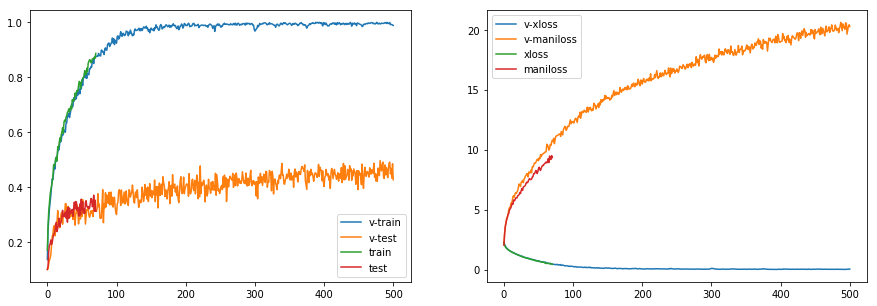

Epoch: 71,Global steps: 1440, xloss: 0.42864, maniloss: 9.31966, training acc: 88.70%, test acc: 34.02%
Epoch: 72,Global steps: 1460, xloss: 0.45873, maniloss: 9.38733, training acc: 85.60%, test acc: 33.86%
Epoch: 73,Global steps: 1480, xloss: 0.43531, maniloss: 9.37182, training acc: 88.90%, test acc: 35.04%
Epoch: 74,Global steps: 1500, xloss: 0.39902, maniloss: 9.61602, training acc: 89.30%, test acc: 35.23%
Epoch: 75,Global steps: 1520, xloss: 0.41126, maniloss: 9.59845, training acc: 89.30%, test acc: 32.59%
Epoch: 76,Global steps: 1540, xloss: 0.38544, maniloss: 9.51065, training acc: 90.70%, test acc: 35.32%
Epoch: 77,Global steps: 1560, xloss: 0.38532, maniloss: 9.44247, training acc: 89.50%, test acc: 32.23%
Epoch: 78,Global steps: 1580, xloss: 0.40158, maniloss: 9.66718, training acc: 89.90%, test acc: 34.56%
Epoch: 79,Global steps: 1600, xloss: 0.35440, maniloss: 10.02267, training acc: 91.90%, test acc: 29.43%
Epoch: 80,Global steps: 1620, xloss: 0.36338, maniloss: 9.80903

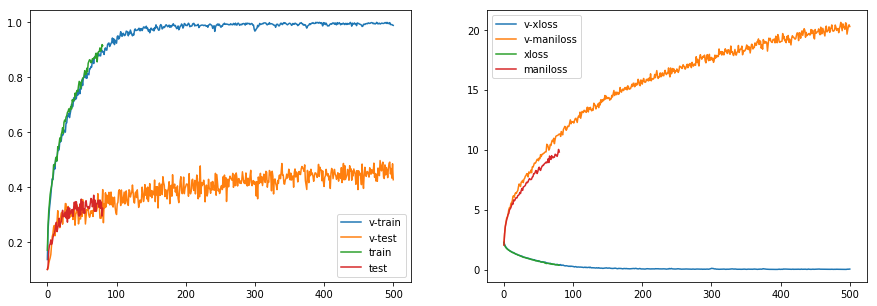

Epoch: 81,Global steps: 1640, xloss: 0.35369, maniloss: 9.84964, training acc: 91.50%, test acc: 37.00%
Epoch: 82,Global steps: 1660, xloss: 0.34544, maniloss: 9.94952, training acc: 91.30%, test acc: 33.17%
Epoch: 83,Global steps: 1680, xloss: 0.32701, maniloss: 9.74231, training acc: 92.70%, test acc: 31.77%
Epoch: 84,Global steps: 1700, xloss: 0.32706, maniloss: 9.86690, training acc: 92.80%, test acc: 34.19%
Epoch: 85,Global steps: 1720, xloss: 0.32337, maniloss: 9.96908, training acc: 92.30%, test acc: 37.87%
Epoch: 86,Global steps: 1740, xloss: 0.32475, maniloss: 9.90182, training acc: 92.90%, test acc: 34.89%
Epoch: 87,Global steps: 1760, xloss: 0.29365, maniloss: 9.98343, training acc: 93.40%, test acc: 33.26%
Epoch: 88,Global steps: 1780, xloss: 0.28694, maniloss: 10.01672, training acc: 93.80%, test acc: 34.61%
Epoch: 89,Global steps: 1800, xloss: 0.29155, maniloss: 10.15233, training acc: 94.00%, test acc: 32.27%
Epoch: 90,Global steps: 1820, xloss: 0.29946, maniloss: 10.094

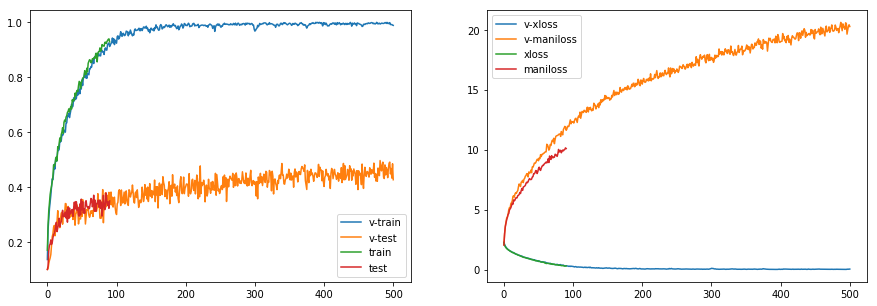

Epoch: 91,Global steps: 1840, xloss: 0.27947, maniloss: 9.97001, training acc: 94.20%, test acc: 36.97%
Epoch: 92,Global steps: 1860, xloss: 0.27990, maniloss: 10.26931, training acc: 93.20%, test acc: 38.29%
Epoch: 93,Global steps: 1880, xloss: 0.28415, maniloss: 10.31690, training acc: 93.40%, test acc: 34.93%
Epoch: 94,Global steps: 1900, xloss: 0.29218, maniloss: 10.30541, training acc: 93.90%, test acc: 32.86%
Epoch: 95,Global steps: 1920, xloss: 0.24992, maniloss: 10.36900, training acc: 95.30%, test acc: 36.64%
Epoch: 96,Global steps: 1940, xloss: 0.25408, maniloss: 10.42295, training acc: 95.10%, test acc: 28.87%
Epoch: 97,Global steps: 1960, xloss: 0.25885, maniloss: 10.33918, training acc: 94.50%, test acc: 36.96%
Epoch: 98,Global steps: 1980, xloss: 0.25216, maniloss: 10.49638, training acc: 94.10%, test acc: 35.56%
Epoch: 99,Global steps: 2000, xloss: 0.26206, maniloss: 10.49150, training acc: 94.50%, test acc: 35.52%
Epoch: 100,Global steps: 2020, xloss: 0.25626, maniloss:

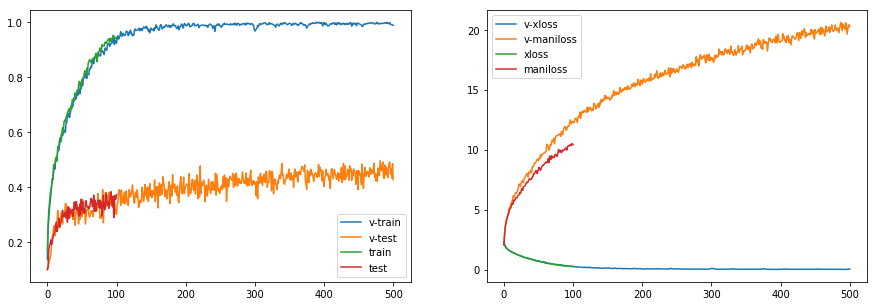

Epoch: 101,Global steps: 2040, xloss: 0.24545, maniloss: 10.34223, training acc: 94.20%, test acc: 38.65%
Epoch: 102,Global steps: 2060, xloss: 0.22517, maniloss: 10.50926, training acc: 95.80%, test acc: 38.97%
Epoch: 103,Global steps: 2080, xloss: 0.23536, maniloss: 10.57581, training acc: 94.40%, test acc: 34.33%
Epoch: 104,Global steps: 2100, xloss: 0.22369, maniloss: 10.35577, training acc: 95.10%, test acc: 35.36%
Epoch: 105,Global steps: 2120, xloss: 0.22529, maniloss: 10.54935, training acc: 95.80%, test acc: 36.82%
Epoch: 106,Global steps: 2140, xloss: 0.20779, maniloss: 10.52159, training acc: 96.00%, test acc: 33.43%
Epoch: 107,Global steps: 2160, xloss: 0.22092, maniloss: 10.50213, training acc: 95.30%, test acc: 35.20%
Epoch: 108,Global steps: 2180, xloss: 0.22197, maniloss: 10.57742, training acc: 95.30%, test acc: 36.20%
Epoch: 109,Global steps: 2200, xloss: 0.18948, maniloss: 10.38965, training acc: 96.10%, test acc: 37.16%
Epoch: 110,Global steps: 2220, xloss: 0.19327,

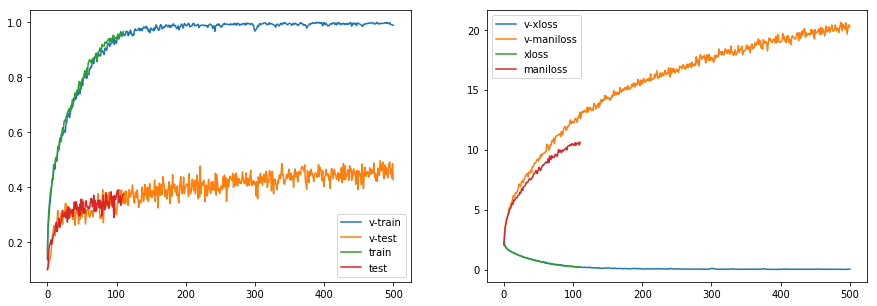

Epoch: 111,Global steps: 2240, xloss: 0.19808, maniloss: 10.48675, training acc: 95.60%, test acc: 37.27%
Epoch: 112,Global steps: 2260, xloss: 0.18977, maniloss: 10.52497, training acc: 96.40%, test acc: 37.81%
Epoch: 113,Global steps: 2280, xloss: 0.18625, maniloss: 10.38107, training acc: 96.50%, test acc: 34.19%
Epoch: 114,Global steps: 2300, xloss: 0.16174, maniloss: 10.61671, training acc: 97.10%, test acc: 37.70%
Epoch: 115,Global steps: 2320, xloss: 0.15800, maniloss: 10.76391, training acc: 97.90%, test acc: 36.46%
Epoch: 116,Global steps: 2340, xloss: 0.17639, maniloss: 10.73833, training acc: 96.90%, test acc: 35.70%
Epoch: 117,Global steps: 2360, xloss: 0.18749, maniloss: 10.63718, training acc: 96.60%, test acc: 36.56%
Epoch: 118,Global steps: 2380, xloss: 0.16616, maniloss: 10.72956, training acc: 97.70%, test acc: 35.97%
Epoch: 119,Global steps: 2400, xloss: 0.18151, maniloss: 10.82065, training acc: 96.00%, test acc: 35.29%
Epoch: 120,Global steps: 2420, xloss: 0.16577,

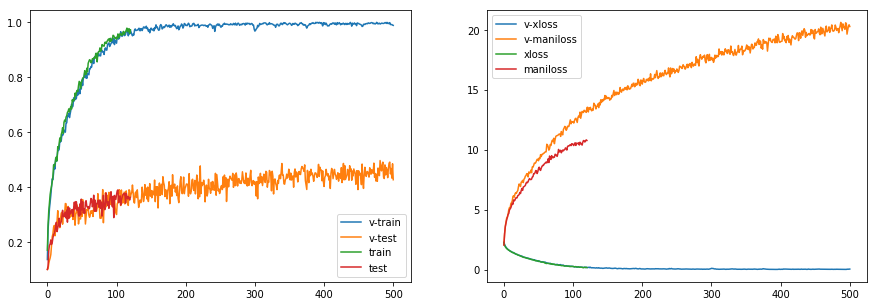

Epoch: 121,Global steps: 2440, xloss: 0.17942, maniloss: 10.71701, training acc: 96.90%, test acc: 37.43%
Epoch: 122,Global steps: 2460, xloss: 0.15687, maniloss: 10.92570, training acc: 97.50%, test acc: 35.93%
Epoch: 123,Global steps: 2480, xloss: 0.14509, maniloss: 10.63953, training acc: 98.20%, test acc: 34.72%
Epoch: 124,Global steps: 2500, xloss: 0.15076, maniloss: 10.74303, training acc: 97.40%, test acc: 40.70%
Epoch: 125,Global steps: 2520, xloss: 0.13166, maniloss: 10.60723, training acc: 98.60%, test acc: 38.05%
Epoch: 126,Global steps: 2540, xloss: 0.14855, maniloss: 10.84348, training acc: 97.10%, test acc: 36.83%
Epoch: 127,Global steps: 2560, xloss: 0.13181, maniloss: 10.72577, training acc: 98.10%, test acc: 35.77%
Epoch: 128,Global steps: 2580, xloss: 0.13579, maniloss: 10.72172, training acc: 98.70%, test acc: 36.55%
Epoch: 129,Global steps: 2600, xloss: 0.13566, maniloss: 10.93153, training acc: 97.80%, test acc: 36.03%
Epoch: 130,Global steps: 2620, xloss: 0.18807,

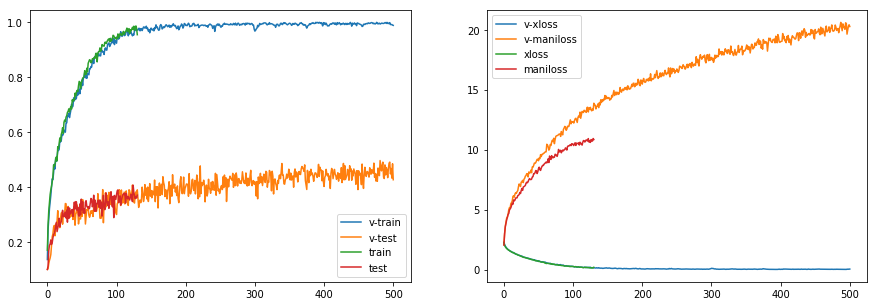

Epoch: 131,Global steps: 2640, xloss: 0.15833, maniloss: 10.69737, training acc: 96.20%, test acc: 40.46%
Epoch: 132,Global steps: 2660, xloss: 0.13750, maniloss: 10.84973, training acc: 98.20%, test acc: 38.34%
Epoch: 133,Global steps: 2680, xloss: 0.12683, maniloss: 10.99503, training acc: 98.00%, test acc: 37.70%
Epoch: 134,Global steps: 2700, xloss: 0.11721, maniloss: 10.82347, training acc: 98.00%, test acc: 34.52%
Epoch: 135,Global steps: 2720, xloss: 0.12738, maniloss: 10.79751, training acc: 97.80%, test acc: 32.52%
Epoch: 136,Global steps: 2740, xloss: 0.11280, maniloss: 10.78804, training acc: 98.80%, test acc: 34.74%
Epoch: 137,Global steps: 2760, xloss: 0.12559, maniloss: 11.01950, training acc: 97.90%, test acc: 39.03%
Epoch: 138,Global steps: 2780, xloss: 0.11350, maniloss: 10.81564, training acc: 98.00%, test acc: 36.82%
Epoch: 139,Global steps: 2800, xloss: 0.13112, maniloss: 10.84310, training acc: 96.80%, test acc: 36.53%
Epoch: 140,Global steps: 2820, xloss: 0.11911,

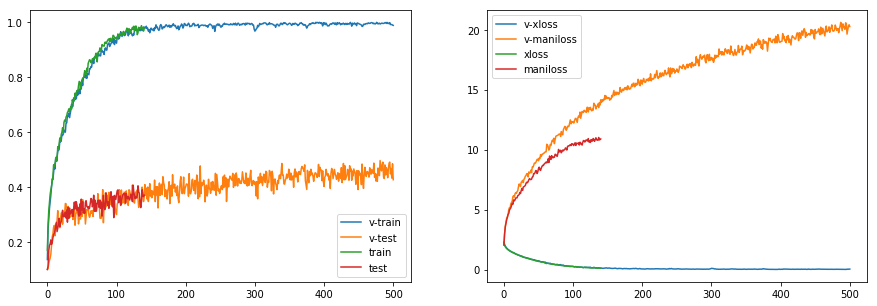

Epoch: 141,Global steps: 2840, xloss: 0.11596, maniloss: 10.82572, training acc: 98.70%, test acc: 35.19%
Epoch: 142,Global steps: 2860, xloss: 0.10423, maniloss: 10.83411, training acc: 98.40%, test acc: 37.42%
Epoch: 143,Global steps: 2880, xloss: 0.13381, maniloss: 10.86734, training acc: 97.20%, test acc: 37.07%
Epoch: 144,Global steps: 2900, xloss: 0.11905, maniloss: 10.85416, training acc: 98.00%, test acc: 38.02%
Epoch: 145,Global steps: 2920, xloss: 0.11317, maniloss: 11.14507, training acc: 98.30%, test acc: 41.45%
Epoch: 146,Global steps: 2940, xloss: 0.12333, maniloss: 10.96569, training acc: 97.70%, test acc: 37.41%
Epoch: 147,Global steps: 2960, xloss: 0.12118, maniloss: 10.93408, training acc: 98.40%, test acc: 36.77%
Epoch: 148,Global steps: 2980, xloss: 0.09807, maniloss: 10.80382, training acc: 99.10%, test acc: 39.18%
Epoch: 149,Global steps: 3000, xloss: 0.10839, maniloss: 10.88924, training acc: 98.10%, test acc: 38.31%
Epoch: 150,Global steps: 3020, xloss: 0.11526,

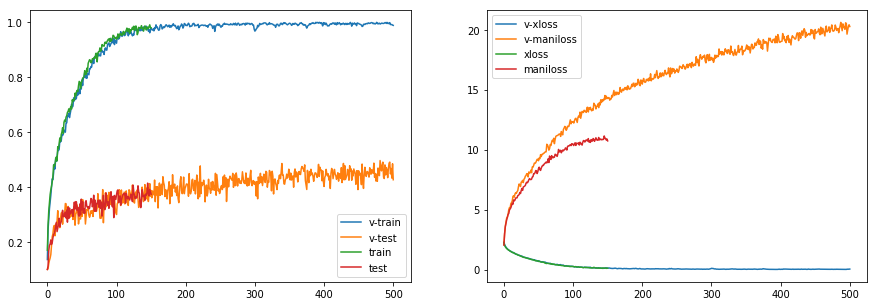

Epoch: 151,Global steps: 3040, xloss: 0.10218, maniloss: 10.95315, training acc: 98.60%, test acc: 38.36%
Epoch: 152,Global steps: 3060, xloss: 0.10754, maniloss: 10.88828, training acc: 97.90%, test acc: 37.39%
Epoch: 153,Global steps: 3080, xloss: 0.10727, maniloss: 10.37823, training acc: 98.20%, test acc: 38.68%
Epoch: 154,Global steps: 3100, xloss: 0.11070, maniloss: 11.02502, training acc: 98.00%, test acc: 40.07%
Epoch: 155,Global steps: 3120, xloss: 0.11144, maniloss: 11.06909, training acc: 98.50%, test acc: 38.61%
Epoch: 156,Global steps: 3140, xloss: 0.12927, maniloss: 10.85744, training acc: 97.20%, test acc: 36.97%
Epoch: 157,Global steps: 3160, xloss: 0.10979, maniloss: 10.79449, training acc: 97.90%, test acc: 40.37%
Epoch: 158,Global steps: 3180, xloss: 0.10088, maniloss: 11.10199, training acc: 98.20%, test acc: 38.64%
Epoch: 159,Global steps: 3200, xloss: 0.07796, maniloss: 11.05554, training acc: 99.30%, test acc: 40.69%
Epoch: 160,Global steps: 3220, xloss: 0.10838,

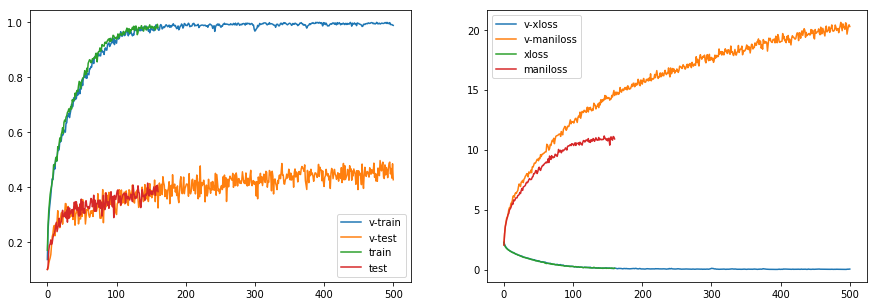

Epoch: 161,Global steps: 3240, xloss: 0.10004, maniloss: 10.98433, training acc: 98.20%, test acc: 39.22%
Epoch: 162,Global steps: 3260, xloss: 0.09663, maniloss: 10.81983, training acc: 98.50%, test acc: 38.47%
Epoch: 163,Global steps: 3280, xloss: 0.10385, maniloss: 10.70986, training acc: 98.20%, test acc: 40.06%
Epoch: 164,Global steps: 3300, xloss: 0.10198, maniloss: 10.72659, training acc: 98.30%, test acc: 40.17%
Epoch: 165,Global steps: 3320, xloss: 0.11037, maniloss: 10.97287, training acc: 97.30%, test acc: 38.86%
Epoch: 166,Global steps: 3340, xloss: 0.10977, maniloss: 10.95220, training acc: 98.00%, test acc: 36.00%
Epoch: 167,Global steps: 3360, xloss: 0.09497, maniloss: 10.88974, training acc: 98.70%, test acc: 36.67%
Epoch: 168,Global steps: 3380, xloss: 0.08856, maniloss: 10.99674, training acc: 98.80%, test acc: 38.06%
Epoch: 169,Global steps: 3400, xloss: 0.08498, maniloss: 10.56552, training acc: 98.90%, test acc: 42.56%
Epoch: 170,Global steps: 3420, xloss: 0.09184,

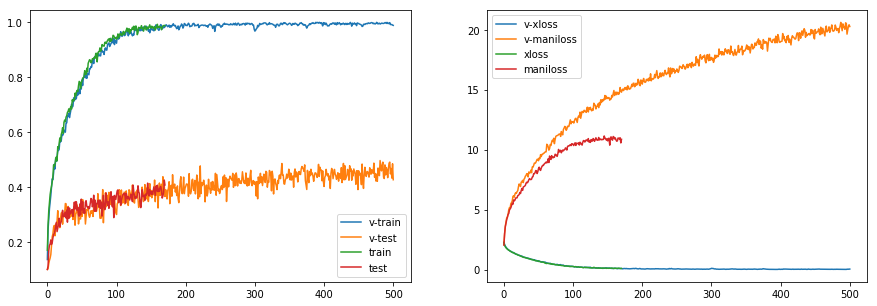

Epoch: 171,Global steps: 3440, xloss: 0.07475, maniloss: 10.86085, training acc: 99.10%, test acc: 41.34%
Epoch: 172,Global steps: 3460, xloss: 0.07517, maniloss: 10.69973, training acc: 98.70%, test acc: 40.87%
Epoch: 173,Global steps: 3480, xloss: 0.08320, maniloss: 10.82932, training acc: 98.80%, test acc: 37.17%
Epoch: 174,Global steps: 3500, xloss: 0.08402, maniloss: 10.79093, training acc: 99.10%, test acc: 38.77%
Epoch: 175,Global steps: 3520, xloss: 0.08159, maniloss: 10.60842, training acc: 98.60%, test acc: 39.67%
Epoch: 176,Global steps: 3540, xloss: 0.07900, maniloss: 10.84174, training acc: 98.70%, test acc: 40.06%
Epoch: 177,Global steps: 3560, xloss: 0.06866, maniloss: 10.74043, training acc: 99.20%, test acc: 39.33%
Epoch: 178,Global steps: 3580, xloss: 0.07394, maniloss: 10.80328, training acc: 99.00%, test acc: 39.09%
Epoch: 179,Global steps: 3600, xloss: 0.07085, maniloss: 10.76782, training acc: 99.30%, test acc: 38.00%
Epoch: 180,Global steps: 3620, xloss: 0.06691,

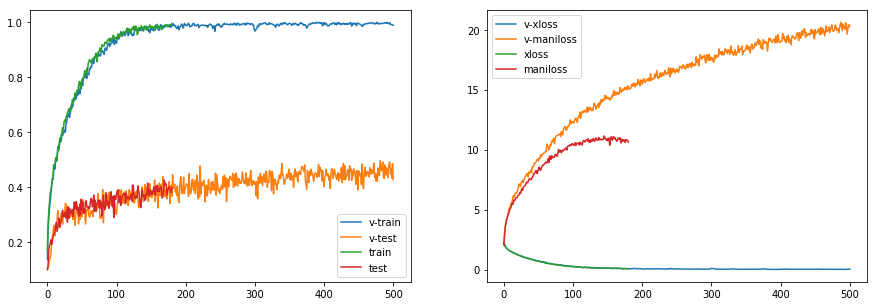

Epoch: 181,Global steps: 3640, xloss: 0.08155, maniloss: 10.84220, training acc: 99.10%, test acc: 40.28%
Epoch: 182,Global steps: 3660, xloss: 0.06290, maniloss: 10.69213, training acc: 99.60%, test acc: 37.99%
Epoch: 183,Global steps: 3680, xloss: 0.06905, maniloss: 10.86527, training acc: 99.20%, test acc: 40.09%
Epoch: 184,Global steps: 3700, xloss: 0.07771, maniloss: 10.60177, training acc: 99.10%, test acc: 40.33%
Epoch: 185,Global steps: 3720, xloss: 0.06321, maniloss: 10.62751, training acc: 99.20%, test acc: 41.00%
Epoch: 186,Global steps: 3740, xloss: 0.06964, maniloss: 10.71848, training acc: 99.00%, test acc: 40.12%
Epoch: 187,Global steps: 3760, xloss: 0.09680, maniloss: 10.64128, training acc: 98.20%, test acc: 43.60%
Epoch: 188,Global steps: 3780, xloss: 0.08395, maniloss: 10.76721, training acc: 98.90%, test acc: 41.13%
Epoch: 189,Global steps: 3800, xloss: 0.07476, maniloss: 10.75736, training acc: 98.80%, test acc: 39.64%
Epoch: 190,Global steps: 3820, xloss: 0.08603,

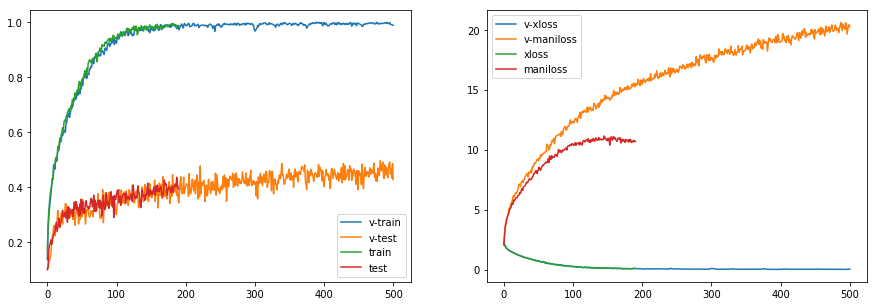

Epoch: 191,Global steps: 3840, xloss: 0.08235, maniloss: 10.75741, training acc: 98.60%, test acc: 41.24%
Epoch: 192,Global steps: 3860, xloss: 0.08448, maniloss: 10.66309, training acc: 98.70%, test acc: 37.65%
Epoch: 193,Global steps: 3880, xloss: 0.06939, maniloss: 10.71138, training acc: 98.90%, test acc: 39.17%
Epoch: 194,Global steps: 3900, xloss: 0.06536, maniloss: 10.59466, training acc: 99.40%, test acc: 40.61%
Epoch: 195,Global steps: 3920, xloss: 0.08352, maniloss: 10.79955, training acc: 98.50%, test acc: 38.85%
Epoch: 196,Global steps: 3940, xloss: 0.06642, maniloss: 10.65494, training acc: 99.60%, test acc: 41.07%
Epoch: 197,Global steps: 3960, xloss: 0.07046, maniloss: 10.50508, training acc: 98.90%, test acc: 41.71%
Epoch: 198,Global steps: 3980, xloss: 0.06907, maniloss: 10.52203, training acc: 99.00%, test acc: 41.25%
Epoch: 199,Global steps: 4000, xloss: 0.06277, maniloss: 10.43794, training acc: 99.30%, test acc: 40.27%
Epoch: 200,Global steps: 4020, xloss: 0.05295,

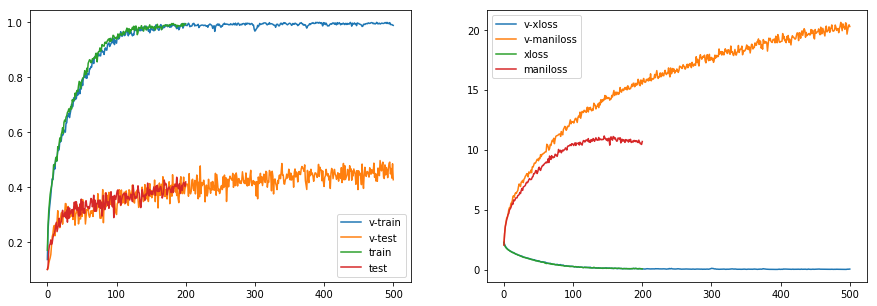

Epoch: 201,Global steps: 4040, xloss: 0.04739, maniloss: 10.46828, training acc: 100.00%, test acc: 39.71%
Epoch: 202,Global steps: 4060, xloss: 0.04886, maniloss: 10.45771, training acc: 99.70%, test acc: 42.43%
Epoch: 203,Global steps: 4080, xloss: 0.05901, maniloss: 10.58940, training acc: 99.50%, test acc: 38.61%
Epoch: 204,Global steps: 4100, xloss: 0.08047, maniloss: 10.49804, training acc: 98.30%, test acc: 39.50%
Epoch: 205,Global steps: 4120, xloss: 0.06562, maniloss: 10.32814, training acc: 99.10%, test acc: 39.89%
Epoch: 206,Global steps: 4140, xloss: 0.06130, maniloss: 10.53424, training acc: 99.50%, test acc: 41.69%
Epoch: 207,Global steps: 4160, xloss: 0.05911, maniloss: 10.61527, training acc: 99.70%, test acc: 39.65%
Epoch: 208,Global steps: 4180, xloss: 0.05746, maniloss: 10.37824, training acc: 99.40%, test acc: 44.20%
Epoch: 209,Global steps: 4200, xloss: 0.05914, maniloss: 10.51326, training acc: 99.20%, test acc: 41.71%
Epoch: 210,Global steps: 4220, xloss: 0.05166

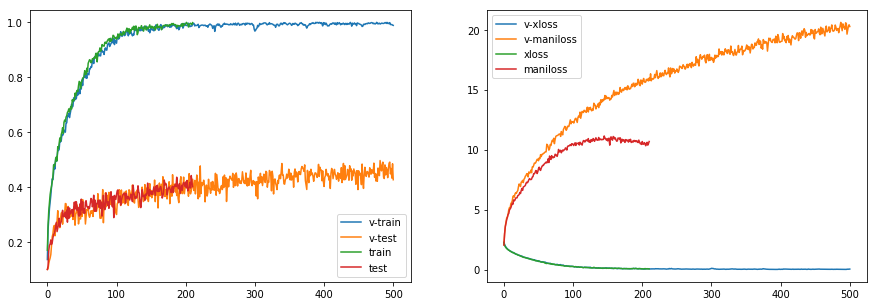

Epoch: 211,Global steps: 4240, xloss: 0.06858, maniloss: 10.84595, training acc: 99.20%, test acc: 39.84%
Epoch: 212,Global steps: 4260, xloss: 0.07504, maniloss: 10.40203, training acc: 98.60%, test acc: 40.49%
Epoch: 213,Global steps: 4280, xloss: 0.06958, maniloss: 10.63773, training acc: 99.00%, test acc: 38.57%
Epoch: 214,Global steps: 4300, xloss: 0.05536, maniloss: 10.44740, training acc: 99.70%, test acc: 42.84%
Epoch: 215,Global steps: 4320, xloss: 0.05077, maniloss: 10.60290, training acc: 99.70%, test acc: 38.66%
Epoch: 216,Global steps: 4340, xloss: 0.04799, maniloss: 10.40555, training acc: 99.40%, test acc: 40.57%
Epoch: 217,Global steps: 4360, xloss: 0.04995, maniloss: 10.42227, training acc: 99.60%, test acc: 40.99%
Epoch: 218,Global steps: 4380, xloss: 0.06027, maniloss: 10.52523, training acc: 99.60%, test acc: 38.89%
Epoch: 219,Global steps: 4400, xloss: 0.07584, maniloss: 10.35428, training acc: 98.70%, test acc: 40.36%
Epoch: 220,Global steps: 4420, xloss: 0.06701,

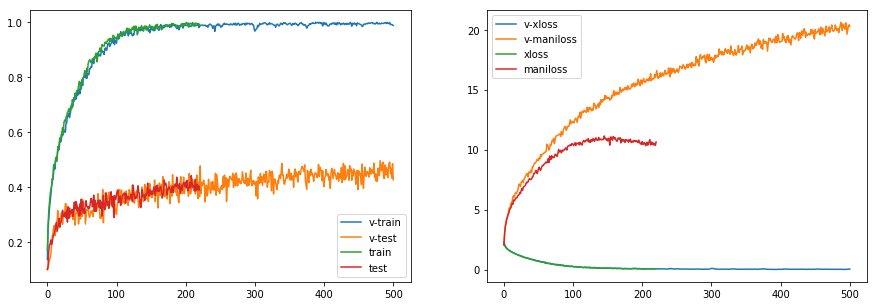

Epoch: 221,Global steps: 4440, xloss: 0.06791, maniloss: 10.29179, training acc: 98.70%, test acc: 40.76%
Epoch: 222,Global steps: 4460, xloss: 0.05483, maniloss: 10.74394, training acc: 99.40%, test acc: 43.42%
Epoch: 223,Global steps: 4480, xloss: 0.05772, maniloss: 10.41662, training acc: 99.30%, test acc: 38.84%
Epoch: 224,Global steps: 4500, xloss: 0.05219, maniloss: 10.49295, training acc: 99.60%, test acc: 39.42%
Epoch: 225,Global steps: 4520, xloss: 0.06322, maniloss: 10.46871, training acc: 99.10%, test acc: 42.52%
Epoch: 226,Global steps: 4540, xloss: 0.05593, maniloss: 10.47104, training acc: 99.20%, test acc: 38.41%
Epoch: 227,Global steps: 4560, xloss: 0.06373, maniloss: 10.09790, training acc: 99.40%, test acc: 44.60%
Epoch: 228,Global steps: 4580, xloss: 0.04941, maniloss: 10.33191, training acc: 99.90%, test acc: 39.24%
Epoch: 229,Global steps: 4600, xloss: 0.04791, maniloss: 10.41360, training acc: 99.70%, test acc: 41.65%
Epoch: 230,Global steps: 4620, xloss: 0.04273,

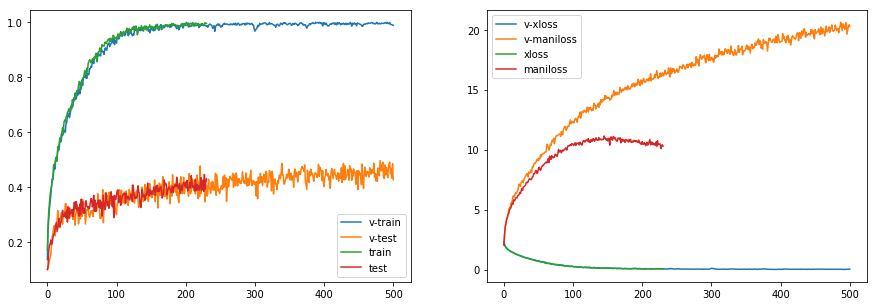

Epoch: 231,Global steps: 4640, xloss: 0.04168, maniloss: 10.19411, training acc: 99.90%, test acc: 43.85%
Epoch: 232,Global steps: 4660, xloss: 0.06179, maniloss: 10.31587, training acc: 99.20%, test acc: 40.53%
Epoch: 233,Global steps: 4680, xloss: 0.06050, maniloss: 10.30565, training acc: 99.20%, test acc: 43.76%
Epoch: 234,Global steps: 4700, xloss: 0.05635, maniloss: 10.55981, training acc: 99.30%, test acc: 43.11%
Epoch: 235,Global steps: 4720, xloss: 0.05301, maniloss: 10.28228, training acc: 99.40%, test acc: 39.11%
Epoch: 236,Global steps: 4740, xloss: 0.06570, maniloss: 10.29122, training acc: 99.00%, test acc: 43.03%
Epoch: 237,Global steps: 4760, xloss: 0.06306, maniloss: 10.21264, training acc: 99.40%, test acc: 40.02%
Epoch: 238,Global steps: 4780, xloss: 0.06879, maniloss: 10.23860, training acc: 98.70%, test acc: 41.18%
Epoch: 239,Global steps: 4800, xloss: 0.06992, maniloss: 10.22290, training acc: 98.80%, test acc: 43.13%
Epoch: 240,Global steps: 4820, xloss: 0.05280,

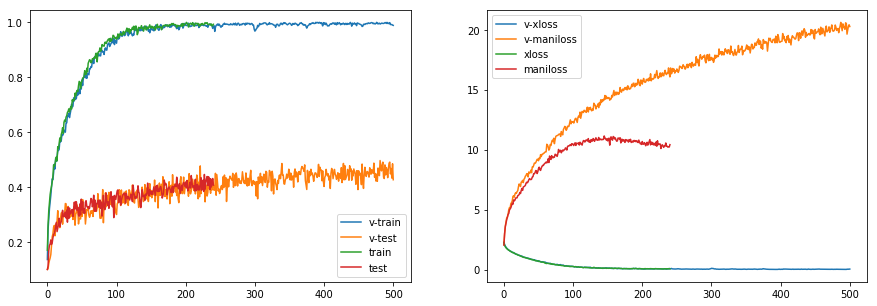

Epoch: 241,Global steps: 4840, xloss: 0.06130, maniloss: 10.42900, training acc: 99.10%, test acc: 40.47%
Epoch: 242,Global steps: 4860, xloss: 0.05123, maniloss: 10.14540, training acc: 99.40%, test acc: 43.31%
Epoch: 243,Global steps: 4880, xloss: 0.04390, maniloss: 9.95686, training acc: 99.50%, test acc: 44.26%
Epoch: 244,Global steps: 4900, xloss: 0.04749, maniloss: 10.06213, training acc: 99.60%, test acc: 41.92%
Epoch: 245,Global steps: 4920, xloss: 0.06169, maniloss: 10.14359, training acc: 99.10%, test acc: 43.84%
Epoch: 246,Global steps: 4940, xloss: 0.05828, maniloss: 10.10829, training acc: 99.10%, test acc: 41.95%
Epoch: 247,Global steps: 4960, xloss: 0.04970, maniloss: 10.07749, training acc: 99.60%, test acc: 42.59%
Epoch: 248,Global steps: 4980, xloss: 0.05866, maniloss: 9.88741, training acc: 99.60%, test acc: 42.27%
Epoch: 249,Global steps: 5000, xloss: 0.04684, maniloss: 10.15274, training acc: 99.30%, test acc: 41.89%
Epoch: 250,Global steps: 5020, xloss: 0.04709, m

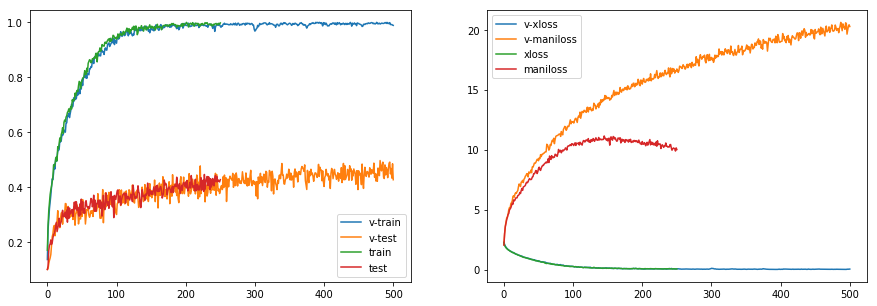

Epoch: 251,Global steps: 5040, xloss: 0.04895, maniloss: 10.18630, training acc: 99.40%, test acc: 40.30%
Epoch: 252,Global steps: 5060, xloss: 0.05269, maniloss: 10.05053, training acc: 99.60%, test acc: 43.53%
Epoch: 253,Global steps: 5080, xloss: 0.03622, maniloss: 10.14312, training acc: 100.00%, test acc: 41.54%
Epoch: 254,Global steps: 5100, xloss: 0.03596, maniloss: 9.92938, training acc: 100.00%, test acc: 42.57%
Epoch: 255,Global steps: 5120, xloss: 0.03881, maniloss: 10.06943, training acc: 99.90%, test acc: 43.54%
Epoch: 256,Global steps: 5140, xloss: 0.03529, maniloss: 10.03711, training acc: 99.60%, test acc: 43.50%
Epoch: 257,Global steps: 5160, xloss: 0.04570, maniloss: 9.76092, training acc: 99.70%, test acc: 44.16%
Epoch: 258,Global steps: 5180, xloss: 0.05015, maniloss: 9.91881, training acc: 99.60%, test acc: 44.29%
Epoch: 259,Global steps: 5200, xloss: 0.04248, maniloss: 10.00594, training acc: 99.70%, test acc: 41.23%
Epoch: 260,Global steps: 5220, xloss: 0.05117, 

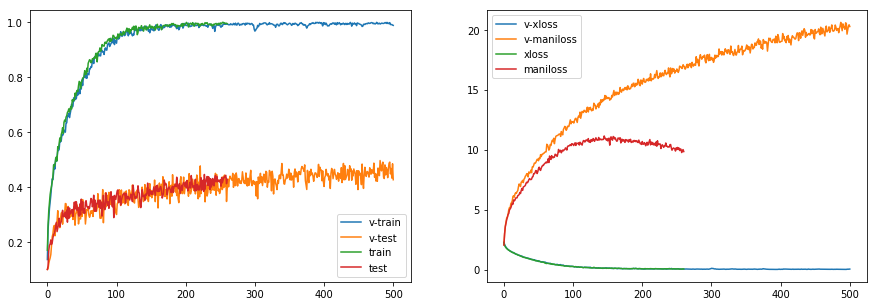

Epoch: 261,Global steps: 5240, xloss: 0.04687, maniloss: 9.96138, training acc: 99.70%, test acc: 43.67%
Epoch: 262,Global steps: 5260, xloss: 0.06980, maniloss: 9.89076, training acc: 98.70%, test acc: 38.75%
Epoch: 263,Global steps: 5280, xloss: 0.04695, maniloss: 9.96192, training acc: 99.70%, test acc: 44.95%
Epoch: 264,Global steps: 5300, xloss: 0.04041, maniloss: 9.88791, training acc: 99.70%, test acc: 41.34%
Epoch: 265,Global steps: 5320, xloss: 0.04430, maniloss: 9.76736, training acc: 99.70%, test acc: 42.36%
Epoch: 266,Global steps: 5340, xloss: 0.04883, maniloss: 9.93289, training acc: 99.50%, test acc: 42.10%
Epoch: 267,Global steps: 5360, xloss: 0.03820, maniloss: 9.76770, training acc: 99.90%, test acc: 41.13%
Epoch: 268,Global steps: 5380, xloss: 0.03530, maniloss: 9.85547, training acc: 99.90%, test acc: 40.43%
Epoch: 269,Global steps: 5400, xloss: 0.04257, maniloss: 9.80556, training acc: 99.80%, test acc: 40.84%
Epoch: 270,Global steps: 5420, xloss: 0.04579, maniloss

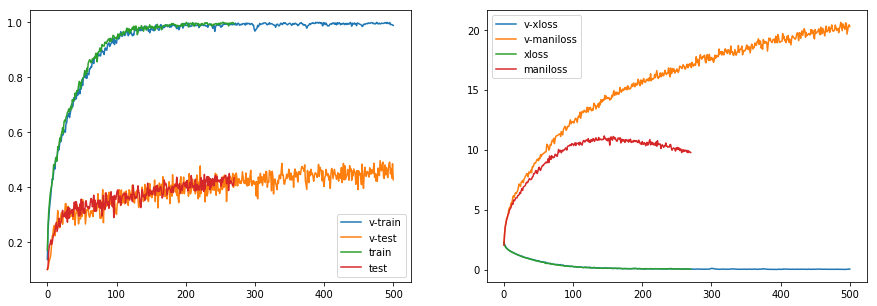

Epoch: 271,Global steps: 5440, xloss: 0.04884, maniloss: 9.79033, training acc: 99.70%, test acc: 41.89%
Epoch: 272,Global steps: 5460, xloss: 0.04321, maniloss: 9.72523, training acc: 99.70%, test acc: 42.13%
Epoch: 273,Global steps: 5480, xloss: 0.03774, maniloss: 9.86431, training acc: 100.00%, test acc: 43.84%
Epoch: 274,Global steps: 5500, xloss: 0.03666, maniloss: 9.75685, training acc: 99.90%, test acc: 43.17%
Epoch: 275,Global steps: 5520, xloss: 0.03834, maniloss: 9.82586, training acc: 99.90%, test acc: 45.21%
Epoch: 276,Global steps: 5540, xloss: 0.03546, maniloss: 9.83673, training acc: 99.70%, test acc: 43.60%
Epoch: 277,Global steps: 5560, xloss: 0.04713, maniloss: 9.63040, training acc: 99.40%, test acc: 40.57%
Epoch: 278,Global steps: 5580, xloss: 0.04397, maniloss: 9.71942, training acc: 99.60%, test acc: 44.76%
Epoch: 279,Global steps: 5600, xloss: 0.04557, maniloss: 9.61195, training acc: 99.80%, test acc: 41.76%
Epoch: 280,Global steps: 5620, xloss: 0.03295, manilos

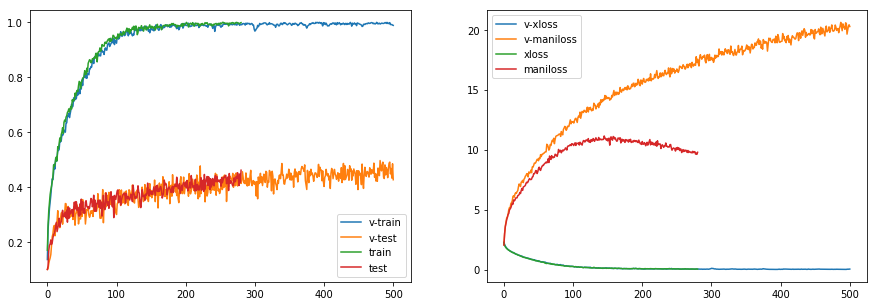

Epoch: 281,Global steps: 5640, xloss: 0.05306, maniloss: 9.78879, training acc: 99.30%, test acc: 42.78%
Epoch: 282,Global steps: 5660, xloss: 0.05338, maniloss: 9.55644, training acc: 99.40%, test acc: 42.20%
Epoch: 283,Global steps: 5680, xloss: 0.07116, maniloss: 9.77530, training acc: 98.70%, test acc: 39.51%
Epoch: 284,Global steps: 5700, xloss: 0.07002, maniloss: 9.56178, training acc: 98.70%, test acc: 43.50%
Epoch: 285,Global steps: 5720, xloss: 0.06374, maniloss: 9.80280, training acc: 98.60%, test acc: 42.25%
Epoch: 286,Global steps: 5740, xloss: 0.07934, maniloss: 9.51164, training acc: 98.20%, test acc: 42.47%
Epoch: 287,Global steps: 5760, xloss: 0.08286, maniloss: 9.84202, training acc: 98.00%, test acc: 42.23%
Epoch: 288,Global steps: 5780, xloss: 0.07996, maniloss: 9.89573, training acc: 98.50%, test acc: 44.89%
Epoch: 289,Global steps: 5800, xloss: 0.06614, maniloss: 10.02864, training acc: 98.80%, test acc: 45.83%
Epoch: 290,Global steps: 5820, xloss: 0.05108, manilos

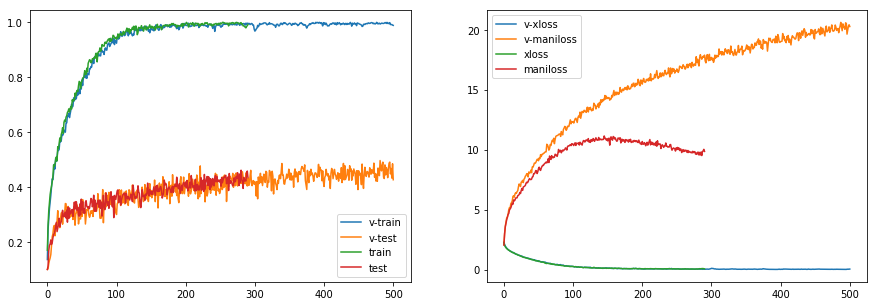

Epoch: 291,Global steps: 5840, xloss: 0.04901, maniloss: 9.69981, training acc: 99.60%, test acc: 41.44%
Epoch: 292,Global steps: 5860, xloss: 0.04125, maniloss: 9.82785, training acc: 99.70%, test acc: 42.78%
Epoch: 293,Global steps: 5880, xloss: 0.04616, maniloss: 9.81509, training acc: 99.40%, test acc: 46.55%
Epoch: 294,Global steps: 5900, xloss: 0.03291, maniloss: 9.66678, training acc: 99.80%, test acc: 42.19%
Epoch: 295,Global steps: 5920, xloss: 0.03280, maniloss: 9.58636, training acc: 99.80%, test acc: 44.09%
Epoch: 296,Global steps: 5940, xloss: 0.03367, maniloss: 9.63989, training acc: 99.90%, test acc: 44.24%
Epoch: 297,Global steps: 5960, xloss: 0.03513, maniloss: 9.46904, training acc: 99.90%, test acc: 43.08%
Epoch: 298,Global steps: 5980, xloss: 0.03524, maniloss: 9.41423, training acc: 99.90%, test acc: 44.84%
Epoch: 299,Global steps: 6000, xloss: 0.03958, maniloss: 9.50125, training acc: 99.80%, test acc: 43.42%
Epoch: 300,Global steps: 6020, xloss: 0.04287, maniloss

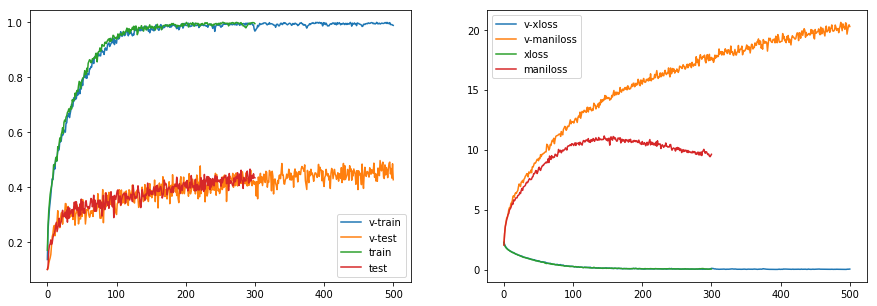

Epoch: 301,Global steps: 6040, xloss: 0.04068, maniloss: 9.42561, training acc: 99.70%, test acc: 45.17%
Epoch: 302,Global steps: 6060, xloss: 0.04305, maniloss: 9.39073, training acc: 99.70%, test acc: 45.58%
Epoch: 303,Global steps: 6080, xloss: 0.03790, maniloss: 9.42315, training acc: 99.40%, test acc: 43.40%
Epoch: 304,Global steps: 6100, xloss: 0.03328, maniloss: 9.39848, training acc: 99.70%, test acc: 43.94%
Epoch: 305,Global steps: 6120, xloss: 0.02710, maniloss: 9.47640, training acc: 100.00%, test acc: 43.55%
Epoch: 306,Global steps: 6140, xloss: 0.03446, maniloss: 9.29927, training acc: 99.70%, test acc: 42.33%
Epoch: 307,Global steps: 6160, xloss: 0.02546, maniloss: 9.38884, training acc: 99.90%, test acc: 46.84%
Epoch: 308,Global steps: 6180, xloss: 0.02965, maniloss: 9.17566, training acc: 99.90%, test acc: 45.08%
Epoch: 309,Global steps: 6200, xloss: 0.02809, maniloss: 9.22534, training acc: 99.90%, test acc: 44.44%
Epoch: 310,Global steps: 6220, xloss: 0.02959, manilos

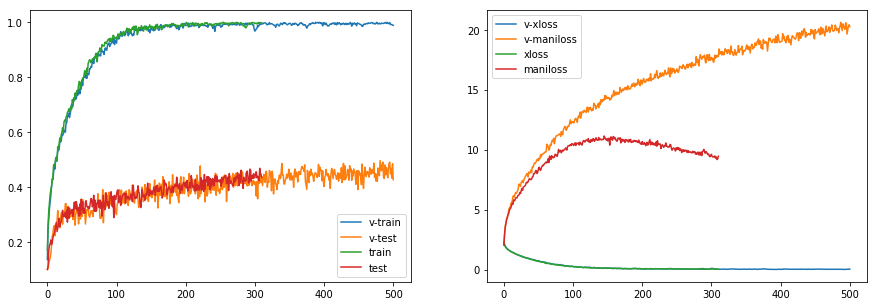

Epoch: 311,Global steps: 6240, xloss: 0.03432, maniloss: 9.29211, training acc: 100.00%, test acc: 42.81%
Epoch: 312,Global steps: 6260, xloss: 0.03339, maniloss: 9.35648, training acc: 99.80%, test acc: 44.17%
Epoch: 313,Global steps: 6280, xloss: 0.02899, maniloss: 9.10584, training acc: 99.90%, test acc: 41.96%
Epoch: 314,Global steps: 6300, xloss: 0.03036, maniloss: 9.28835, training acc: 99.70%, test acc: 44.98%
Epoch: 315,Global steps: 6320, xloss: 0.03991, maniloss: 9.23985, training acc: 99.80%, test acc: 45.08%
Epoch: 316,Global steps: 6340, xloss: 0.03823, maniloss: 9.26849, training acc: 99.70%, test acc: 42.78%
Epoch: 317,Global steps: 6360, xloss: 0.03654, maniloss: 9.16860, training acc: 99.90%, test acc: 44.45%
Epoch: 318,Global steps: 6380, xloss: 0.03356, maniloss: 9.39439, training acc: 99.70%, test acc: 42.66%
Epoch: 319,Global steps: 6400, xloss: 0.03539, maniloss: 9.15049, training acc: 99.70%, test acc: 43.66%
Epoch: 320,Global steps: 6420, xloss: 0.03489, manilos

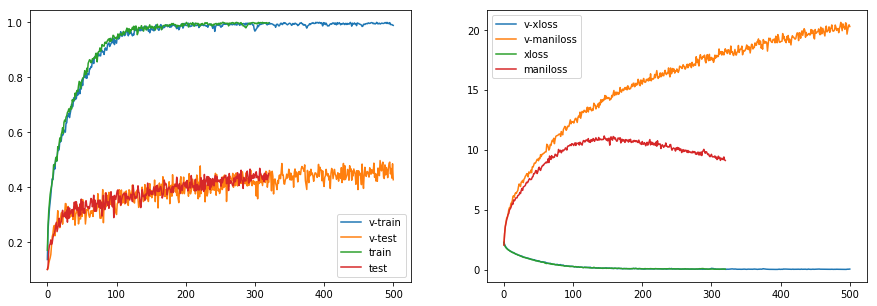

Epoch: 321,Global steps: 6440, xloss: 0.02806, maniloss: 9.15371, training acc: 99.90%, test acc: 46.18%
Epoch: 322,Global steps: 6460, xloss: 0.02323, maniloss: 9.14072, training acc: 99.90%, test acc: 43.52%
Epoch: 323,Global steps: 6480, xloss: 0.02842, maniloss: 9.08140, training acc: 99.80%, test acc: 42.36%
Epoch: 324,Global steps: 6500, xloss: 0.03658, maniloss: 8.88206, training acc: 99.50%, test acc: 40.56%
Epoch: 325,Global steps: 6520, xloss: 0.04388, maniloss: 9.16148, training acc: 99.60%, test acc: 45.15%
Epoch: 326,Global steps: 6540, xloss: 0.04032, maniloss: 9.09368, training acc: 99.60%, test acc: 47.50%
Epoch: 327,Global steps: 6560, xloss: 0.03460, maniloss: 9.21378, training acc: 99.90%, test acc: 44.28%
Epoch: 328,Global steps: 6580, xloss: 0.02759, maniloss: 9.36376, training acc: 99.80%, test acc: 43.34%
Epoch: 329,Global steps: 6600, xloss: 0.03078, maniloss: 9.09991, training acc: 99.90%, test acc: 44.13%
Epoch: 330,Global steps: 6620, xloss: 0.03645, maniloss

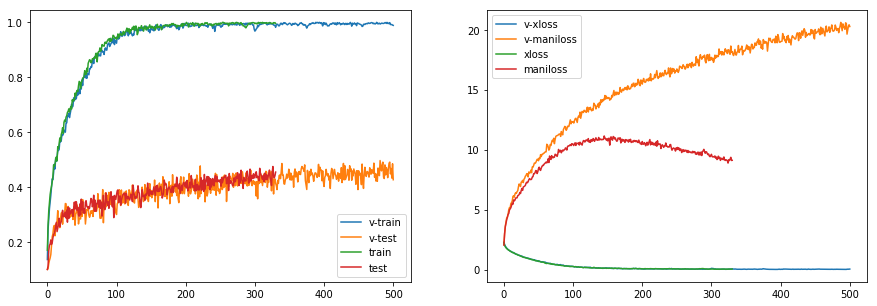

Epoch: 331,Global steps: 6640, xloss: 0.03337, maniloss: 8.99796, training acc: 100.00%, test acc: 46.37%
Epoch: 332,Global steps: 6660, xloss: 0.02761, maniloss: 9.03346, training acc: 100.00%, test acc: 46.47%
Epoch: 333,Global steps: 6680, xloss: 0.04476, maniloss: 8.94143, training acc: 99.20%, test acc: 46.71%
Epoch: 334,Global steps: 6700, xloss: 0.04338, maniloss: 8.95531, training acc: 99.70%, test acc: 44.25%
Epoch: 335,Global steps: 6720, xloss: 0.04620, maniloss: 9.44147, training acc: 99.40%, test acc: 45.10%
Epoch: 336,Global steps: 6740, xloss: 0.04358, maniloss: 9.10522, training acc: 99.60%, test acc: 46.57%
Epoch: 337,Global steps: 6760, xloss: 0.04316, maniloss: 9.07885, training acc: 99.60%, test acc: 43.23%
Epoch: 338,Global steps: 6780, xloss: 0.03516, maniloss: 9.26574, training acc: 99.70%, test acc: 46.22%
Epoch: 339,Global steps: 6800, xloss: 0.03044, maniloss: 9.10148, training acc: 99.80%, test acc: 42.83%
Epoch: 340,Global steps: 6820, xloss: 0.03707, manilo

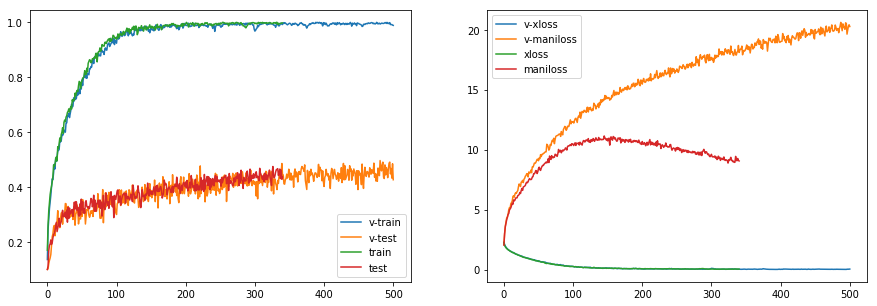

Epoch: 341,Global steps: 6840, xloss: 0.03863, maniloss: 9.16729, training acc: 99.70%, test acc: 45.33%
Epoch: 342,Global steps: 6860, xloss: 0.04010, maniloss: 9.16368, training acc: 99.60%, test acc: 44.14%
Epoch: 343,Global steps: 6880, xloss: 0.04430, maniloss: 9.11437, training acc: 99.20%, test acc: 43.34%
Epoch: 344,Global steps: 6900, xloss: 0.03581, maniloss: 9.09124, training acc: 99.90%, test acc: 45.22%
Epoch: 345,Global steps: 6920, xloss: 0.03818, maniloss: 8.96821, training acc: 99.90%, test acc: 45.12%
Epoch: 346,Global steps: 6940, xloss: 0.03064, maniloss: 8.75395, training acc: 99.70%, test acc: 47.46%
Epoch: 347,Global steps: 6960, xloss: 0.03316, maniloss: 8.94438, training acc: 99.80%, test acc: 46.55%
Epoch: 348,Global steps: 6980, xloss: 0.02982, maniloss: 9.19024, training acc: 99.80%, test acc: 44.97%
Epoch: 349,Global steps: 7000, xloss: 0.03175, maniloss: 8.90764, training acc: 99.90%, test acc: 42.65%
Epoch: 350,Global steps: 7020, xloss: 0.03037, maniloss

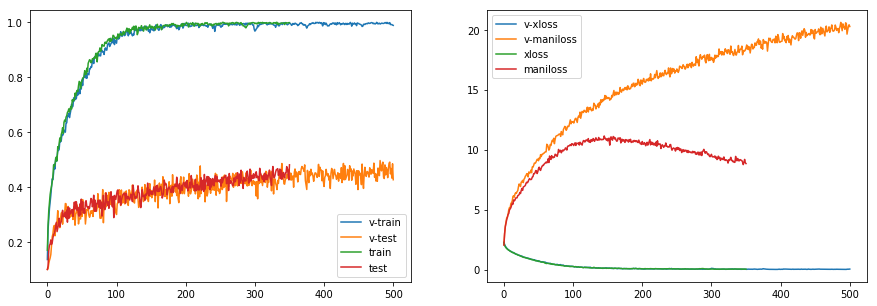

Epoch: 351,Global steps: 7040, xloss: 0.02234, maniloss: 8.88851, training acc: 100.00%, test acc: 44.78%
Epoch: 352,Global steps: 7060, xloss: 0.02650, maniloss: 8.77034, training acc: 99.90%, test acc: 44.29%
Epoch: 353,Global steps: 7080, xloss: 0.04325, maniloss: 8.78322, training acc: 99.60%, test acc: 44.65%
Epoch: 354,Global steps: 7100, xloss: 0.03824, maniloss: 8.79091, training acc: 99.90%, test acc: 46.89%
Epoch: 355,Global steps: 7120, xloss: 0.02985, maniloss: 8.91848, training acc: 99.70%, test acc: 44.47%
Epoch: 356,Global steps: 7140, xloss: 0.03610, maniloss: 8.94880, training acc: 99.80%, test acc: 43.74%
Epoch: 357,Global steps: 7160, xloss: 0.03880, maniloss: 8.71918, training acc: 99.40%, test acc: 45.87%
Epoch: 358,Global steps: 7180, xloss: 0.03417, maniloss: 8.84888, training acc: 99.80%, test acc: 44.79%


In [ ]:
for epoch in tqdm(range(params_dnn['epoch'])):
    inds = rng.permutation(trainx.shape[0])
    trainx = trainx[inds]
    trainy = trainy[inds]
    train_acc=test_acc=train_loss=train_manifold=0
    
    for step in range(nr_batch_train):
        ran_from = step * params_dnn['batch']
        ran_to = (step+1) * params_dnn['batch']
        xl, _ , acc,ml =  sess.run([xloss,train_op, accuracy,manifold_loss], {inp: trainx[ran_from:ran_to],
                                                                             lbl: trainy[ran_from:ran_to],
                                                                             is_training_pl:False,
                                                                             training_cnn:True})
        train_acc += acc; train_loss += xl; train_manifold += ml
    train_acc /= nr_batch_train; train_loss /= nr_batch_train; train_manifold /= nr_batch_train
    train_array.append(train_acc);loss_array.append(train_loss);manifold_array.append(train_manifold)
    for step in range(nr_batch_test):
        ran_from = step * params_dnn['batch']
        ran_to = (step+1) * params_dnn['batch']
        test_acc += sess.run(accuracy, {inp: testx[ran_from:ran_to],
                                         lbl: testy[ran_from:ran_to],
                                         training_cnn:False})
    test_acc /= nr_batch_test; test_array.append(test_acc)
    print("Epoch: {},Global steps: {}, xloss: {:.5f}, maniloss: {:.5f}, training acc: {:.2f}%, test acc: {:.2f}%".format(
            epoch, sess.run(global_step),train_loss, train_manifold,train_acc * 100,test_acc*100))
    
    if (epoch != 0) & (epoch % 10 == 0):
        plt.figure(figsize=(15,5))
        plt.subplot(121)
        plt.plot(v_train)
        plt.plot(v_test)
        plt.plot(train_array)
        plt.plot(test_array)
        plt.legend(['v-train','v-test','train','test'])
        plt.subplot(122)
        plt.plot(v_loss)
        plt.plot(v_mani)
        plt.plot(loss_array)
        plt.plot(manifold_array)
        plt.legend(['v-xloss','v-maniloss','xloss','maniloss'])
        plt.show()

In [34]:
# v_train = train_array
# v_test = test_array
# v_loss = loss_array
# v_mani = manifold_array

# t0_train = train_array #sans pz et gamma = 0.03
# t0_test = test_array
# t0_loss = loss_array
# t0_mani = manifold_array

# t1_train = train_array #avec pz et gamma = 0.01
# t1_test = test_array
# t1_loss = loss_array
# t1_mani = manifold_array

# t1_train = train_array #avec pz et gamma = 0.01
# t1_test = test_array
# t1_loss = loss_array
# t1_mani = manifold_array

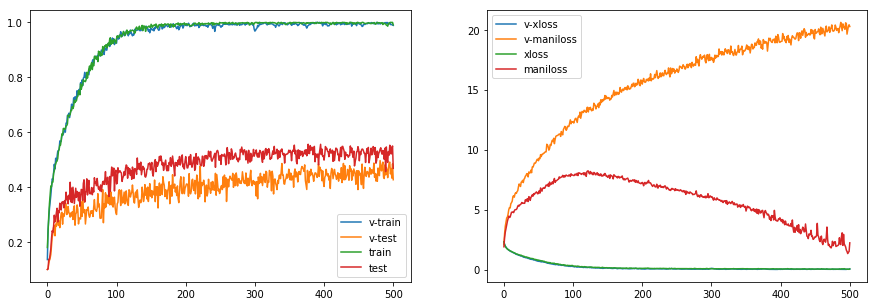

In [35]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(v_train)
plt.plot(v_test)
plt.plot(train_array)
plt.plot(test_array)
plt.legend(['v-train','v-test','train','test'])
plt.subplot(122)
plt.plot(v_loss)
plt.plot(v_mani)
plt.plot(loss_array)
plt.plot(manifold_array)
plt.legend(['v-xloss','v-maniloss','xloss','maniloss'])
plt.show()